# ReAct Agent with Human in the Loop
Agentがツールを実行する際に必要な引数をユーザーに尋ねる例。

ReAct AgentにHILを組み込んで、ユーザーの入力を待つ。  

- agent_node(https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/#agent)

## セットアップ

(memo) 2025/05/16 LangGraph 0.4.4がリリースされた直後に`from langgraph.graph import START`をやるとimportエラーになるので暫定で1つ前のバージョンを指定した。

In [7]:
%pip install -qU langgraph==0.4.3 langchain-community langchain-openai tavily-python python-dotenv

Note: you may need to restart the kernel to use updated packages.


## 環境変数

In [10]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"] = "langchain-study"

## 実装
- [ReAct Agent Scratch](https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch/)に対してHILを組み込むイメージ。

- `ToolNode()`: https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.chat_agent_executor.create_react_

`@tool`デコレータをクラスに付ける
Agentにクラスで指定した形式で出力させる
- LangChainの`@tool`をPythonのクラスにつける例の紹介 #LangChain(https://blog.generative-agents.co.jp/entry/2025/05/14/222647)

In [11]:
from langgraph.graph import MessagesState, START
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from langgraph.types import interrupt
from langgraph.graph import END, StateGraph

# ツールの定義
@tool
def search(location: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return f"I looked up: {location}. Result: It's sunny in {location}, but you better look out if you're a Gemini 😈."

# AskHumanというダミーツールを定義
# クラスに@toolをつけてツールとして扱う場合、tool_callのargsはクラスのフィールドになる
# AgentにAskHumanの形式で出力させる
# このツールが呼ばれたらAgentはask_human_node()を呼び出す
class AskHuman(BaseModel):
    """Ask the human a question"""
    question: str


tools = [search, AskHuman]


# モデルの定義
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
model=model.bind_tools(tools)
# model = model.bind_tools(tools + [AskHuman])


# Nodeの定義
# モデルを実行するNodeの定義
def agent_node(state):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}

# ユーザーにツール実行を確認するNodeの定義
def ask_human_node(state):
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    ask = AskHuman.model_validate(state["messages"][-1].tool_calls[0]["args"])  # BaseModelのmodel_validate()メソッドでtool_callのargsをvalidation
    location = interrupt(ask.question)  # AskHumanがツールとして実行された場合、argsはAskHumanクラスのフィールドになるのでquestionを取得してinterrupt()でユーザーに尋ねる
    tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": location}]
    return {"messages": tool_message}

# ツールを実行するNodeの定義
tool_node = ToolNode(tools)


# LLMからの応答に応じて分岐を行うための関数を定義
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:  # 応答にtool_callsが含まれていなければEND Nodeへ
        return END
    elif last_message.tool_calls[-1]["name"] == "AskHuman":  # AskHumanがツールとして実行(tool_callsにAskHumanが含まれている)されたらask_human_nodeへ
        return "ask_human_node"
    else:
        return "tool_node"

# グラフの定義
workflow = StateGraph(MessagesState)


workflow.add_node("agent_node", agent_node)
workflow.add_node("tool_node", tool_node)
workflow.add_node("ask_human_node", ask_human_node)


workflow.add_edge(START, "agent_node")

workflow.add_conditional_edges(
    "agent_node",
    should_continue,
    path_map=["ask_human_node", "tool_node", END],
)

workflow.add_edge("tool_node", "agent_node")

workflow.add_edge("ask_human_node", "agent_node")

# Set up memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


graph = workflow.compile(checkpointer=memory)

## グラフの描画

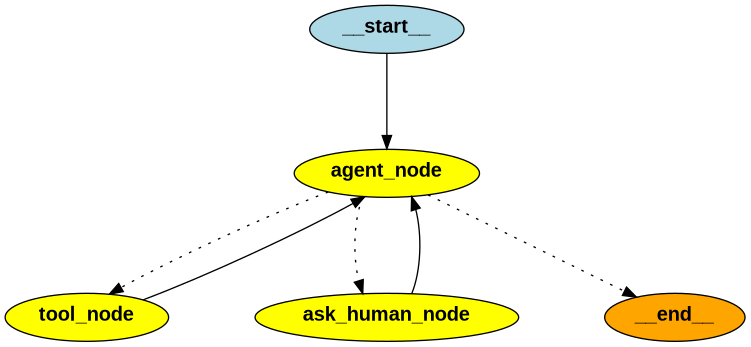

In [12]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

## 実行

In [13]:
from langgraph.types import Command
import random

inputs = {"messages": [("user","ユーザーにどこにいるのか尋ねてください。そして、ユーザーがいる場所の天気を調べてください。")]}

# Thread
num = random.randint(1, 10)
thread = {"configurable": {"thread_id": num}}

result = graph.invoke(inputs, config=thread)

# Graphがinterruptで中断されているかをチェック
if "__interrupt__" in result and result["__interrupt__"] is not None:
    print(result["__interrupt__"][-1].value)
    user_message = input()
    result = graph.invoke(Command(resume=user_message), config=thread)

print(result["messages"][-1].content)

あなたはどこにいますか？
東京の天気は晴れです。ただし、双子座の方は注意が必要かもしれませんね。😈
